In [1]:
#############
# SREX masks
#############


import numpy as np
import netCDF4 as net
import dimarray as da 
import sys
import itertools
import glob
import datetime
import pickle
import os
import pandas as pd
import matplotlib.pylab as plt 
from six import string_types
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6

sys.path.append('/Users/peterpfleiderer/Documents/0p5_observed/')

try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")



In [2]:
# from get_area.py
import sys

import datetime
import numpy as np
from mpl_toolkits.basemap import Basemap

sys.path.append('/Users/peterpfleiderer/Documents/economic-growth-and-climate-change/')
from NCFile2 import NCFileReader, NCFileWriter
sys.path.append('/Users/peterpfleiderer/Documents/0p5_observed/')

from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt



def get_grid_polygons(fnm,shift_lon=0.0):
    print 'Read grid information and create polygons according to the projection.'

    nc = NCFileReader(fnm)
    lat = np.array(nc.get_lat()).squeeze()
    lon = np.array(nc.get_lon()).squeeze()+shift_lon
    nc.close()

    nx = len(lon)
    ny = len(lat)
    # loop over the grid to get dird polygons
    grid_polygons = np.empty((nx,ny),dtype=Polygon)
    dx = np.zeros((nx))
    dy = np.zeros((ny))
    dx[1:] = np.abs(np.diff(lon,1))
    dx[0] = dx[1]
    dy[1:] = np.abs(np.diff(lat,1))
    dy[0] = dy[1]
    for i in range(nx):
        x1 = lon[i]-dx[i]/2.
        x2 = lon[i]+dx[i]/2.
        for j in range(ny):
            y1 = lat[j]-dy[j]/2.
            y2 = lat[j]+dy[j]/2.
            grid_polygons[i,j] = Polygon([(x1,y1),(x1,y2),(x2,y2),(x2,y1)])

    return (lon-shift_lon, lat), grid_polygons

def get_area_fraction_lat_dep(country,grid_polygons):
    nx = len(grid_polygons[:,0])
    ny = len(grid_polygons[0,:])
    overlap = np.zeros((ny,nx))
    for i in range(nx):
        for j in range(ny):
            intersect = grid_polygons[i,j].intersection(country).area/grid_polygons[i,j].area*country.area
            overlap[j,i] = intersect*np.cos(np.radians(lat[j]))

    overlap_zwi=overlap.copy()
    overlap_sum=sum(overlap_zwi.flatten())
    if overlap_sum!=0:
        output=np.zeros(overlap.shape)
        output=overlap/overlap_sum
        
    output[output==0]=np.nan
    output=np.ma.masked_invalid(output)
    return np.roll(output,shift,axis=1)
    #return output



In [191]:
# Variable
varin='TX90p'
inFile='/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc'
#read_in_data=da.read_nc(inFile)['Ann']



srex_polygons = np.load('srex_dict.dat')

shift_lon=-180.0
(lon, lat), grid_polygons = get_grid_polygons(inFile,shift_lon)
shift = len(lon)-np.where(lon==lon[0]-shift_lon)[0][0]


Read grid information and create polygons according to the projection.
open /Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_TX90p_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc
96
73
POLYGON ((-181.875 -91.25, -181.875 -88.75, -178.125 -88.75, -178.125 -91.25, -181.875 -91.25))
POLYGON ((-181.875 88.75, -181.875 91.25, -178.125 91.25, -178.125 88.75, -181.875 88.75))
POLYGON ((174.375 88.75, 174.375 91.25, 178.125 91.25, 178.125 88.75, 174.375 88.75))
POLYGON ((174.375 -91.25, 174.375 -88.75, 178.125 -88.75, 178.125 -91.25, 174.375 -91.25))


In [182]:
for region in srex_polygons.keys():
    #if region=='CEU':
    if True:
        points=[]
        for point in srex_polygons[region]['poly']:
            points.append(tuple(list(point[::-1])))
        srex_polygons[region]['points']=points
        #print region,points
        srex_polygons[region]['mask']=get_area_fraction_lat_dep(Polygon(points),grid_polygons)


(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)
(73, 96)


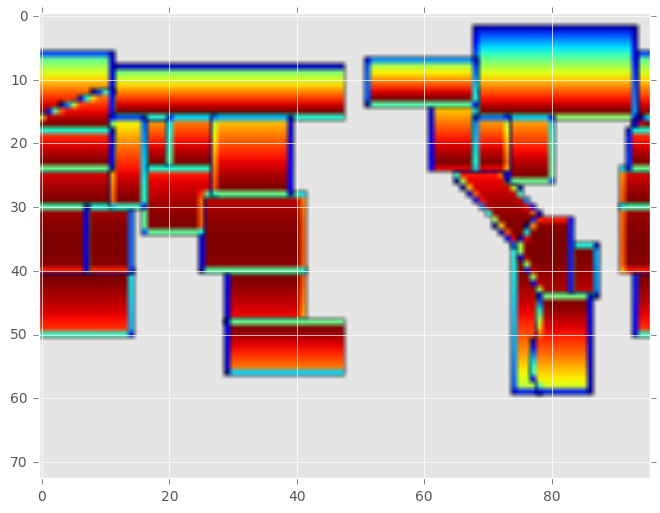

In [185]:
for region in srex_polygons.keys():
    plt.imshow(srex_polygons[region]['mask'][::-1,:])
plt.show()

In [179]:
def plot_country_polygons(mask,poly):
    ax=Basemap(llcrnrlon=-180,urcrnrlon=360,llcrnrlat=-90,urcrnrlat=90)
    step = np.diff(lat,1)[0]
    lats = np.arange(lat[0]-step,lat[-1]+step,step)
    lats = lats+step/2

    step = np.diff(lon,1)[0]
    lons = np.arange(lon[0]-step,lon[-1]+step,step)
    lons = lons+step/2
    #lons[lons<0]+=360
        

    Z=mask.reshape([len(lat),len(lon)])

    im1 = ax.pcolormesh(lons,lats,Z,cmap=plt.cm.BrBG)

    #lons, lats = np.meshgrid(lons,lats)

    x, y = poly.exterior.xy
    ax.plot(x,y,'r-',c='g')
    return lons

[  -1.875    1.875    5.625    9.375   13.125   16.875   20.625   24.375
   28.125   31.875   35.625   39.375   43.125   46.875   50.625   54.375
   58.125   61.875   65.625   69.375   73.125   76.875   80.625   84.375
   88.125   91.875   95.625   99.375  103.125  106.875  110.625  114.375
  118.125  121.875  125.625  129.375  133.125  136.875  140.625  144.375
  148.125  151.875  155.625  159.375  163.125  166.875  170.625  174.375
  178.125  181.875  185.625  189.375  193.125  196.875  200.625  204.375
  208.125  211.875  215.625  219.375  223.125  226.875  230.625  234.375
  238.125  241.875  245.625  249.375  253.125  256.875  260.625  264.375
  268.125  271.875  275.625  279.375  283.125  286.875  290.625  294.375
  298.125  301.875  305.625  309.375  313.125  316.875  320.625  324.375
  328.125  331.875  335.625  339.375  343.125  346.875  350.625  354.375
  358.125]
[   0.      3.75    7.5    11.25   15.     18.75   22.5    26.25   30.
   33.75   37.5    41.25   45.     48.75  

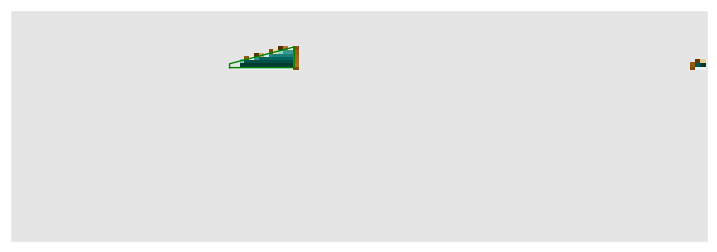

In [180]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(9,8))

region='CEU'
print plot_country_polygons(srex_polygons[region]['mask'][:,:],poly=Polygon(srex_polygons[region]['points']))

print lon
plt.show()

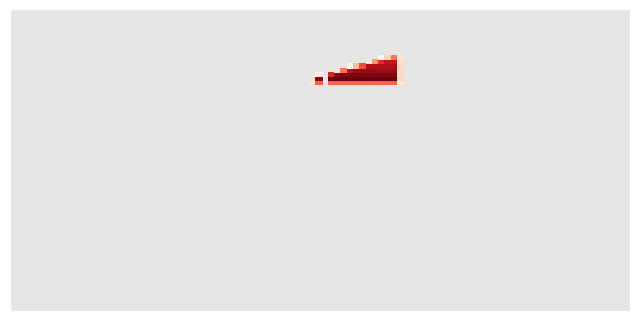

In [137]:
ax=Basemap(llcrnrlon=-10,urcrnrlon=360,llcrnrlat=-90,urcrnrlat=90,resolution="l",projection='cyl')  
#ax.pcolormesh(lon,lat,srex_polygons['CEU']['mask'],cmap=plt.cm.Reds)
ax.pcolormesh(np.roll(lon,shift),lat,np.roll(srex_polygons['CEU']['mask'],shift,axis=1),cmap=plt.cm.Reds)
plt.show()

In [138]:
print srex_polygons['CEU']['mask']
print 

[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]]


In [134]:
print len(lons)
print len(lon)


97
96
